# Library

In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
import gzip

from prml.utils.encoder import LabelToOnehot

# KMeans

In [2]:
class KMeans():
    def __init__(self,K,max_iter=100):
        self.K = K 
        self.max_iter = max_iter

    def fit(self,X,init_prototype=None):

        if init_prototype is None:
            init_prototype = np.random.randn(self.K,X.shape[1]) 
        prototype = init_prototype
        cluster = np.zeros(X.shape[0])
        
        for _ in range(self.max_iter):
            changed = 0

            # E step 
            for i in range(X.shape[0]):
                dist = np.sum((X[i] - prototype)**2,axis = 1) 
                min_dist_idx = np.argmin(dist)  
                if cluster[i] != min_dist_idx:
                    changed += 1
                cluster[i] = min_dist_idx
            
            # M step
            for i in range(self.K):
                if np.all(cluster != i):
                    continue
                prototype[i] = np.mean(X[cluster == i],axis = 0)
            
            if changed == 0:
                break 
        
        return cluster,prototype

In [3]:
def make_data(n = 100,cluster = 2):
    if cluster == 2:
        X1 = np.random.randn(n,2) + 1 
        X2 = np.random.randn(n,2) - 1 
        X = np.vstack((X1,X2))
    elif cluster == 3: 
        X1 = np.random.randn(n,2) + 1 
        X2 = np.random.randn(n,2) - 1 
        X3 = np.random.randn(n,2) + np.array([0,1]) + np.array([-1,0])
        X = np.vstack((X1,X2,X3))
    return X

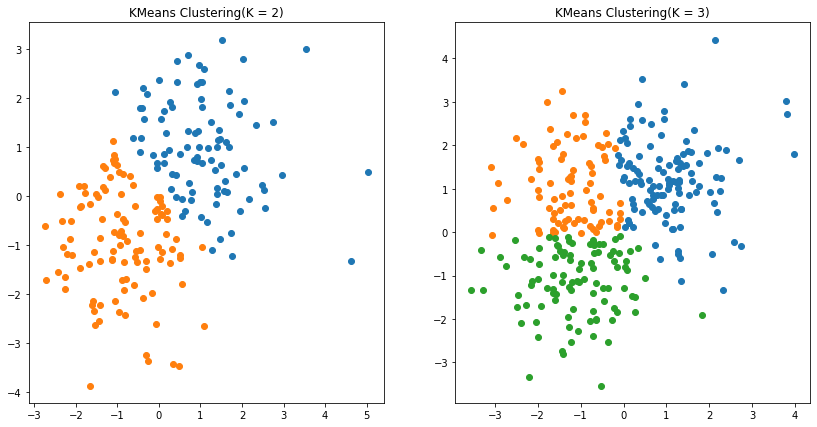

In [4]:
X2 = make_data(cluster=2)
X3 = make_data(cluster=3) 
km2 = KMeans(K = 2)
km3 = KMeans(K = 3)
cluster2,_ = km2.fit(X2) 
cluster3,_ = km3.fit(X3)

fig,ax = plt.subplots(1,2,figsize=(14,7)) 
ax[0].scatter(X2[cluster2 == 0,0],X2[cluster2 == 0,1])
ax[0].scatter(X2[cluster2 == 1,0],X2[cluster2 == 1,1])
ax[0].set_title("KMeans Clustering(K = 2)")

ax[1].scatter(X3[cluster3 == 0,0],X3[cluster3 == 0,1])
ax[1].scatter(X3[cluster3 == 1,0],X3[cluster3 == 1,1])
ax[1].scatter(X3[cluster3 == 2,0],X3[cluster3 == 2,1])
ax[1].set_title("KMeans Clustering(K = 3)")
plt.show()

# Ancestral Sampling

In [5]:
def gm_sampling(n=100,pi=None,mu=None,sigma=None):
    if pi is None:
        assert mu is None and sigma is None 
        pi = np.ones((3)) / 3 
        mu = np.array([
            np.array([1,1]),
            np.array([-1,-1]),
            np.array([1,-1])
        ])
        sigma = np.array([np.eye(2) for _ in range(3)])
    
    z = np.random.multinomial(1,pi,size=n) 
    X = np.zeros((n,mu.shape[1])) 
    N = np.sum(z,axis = 0)
    for k in range(pi.shape[0]):
        n_k = N[k]
        X[z[:,k] == 1,:] = np.random.multivariate_normal(mu[k],sigma[k],n_k)
    return X 

In [6]:
pi = np.array([1/3,1/3,1/3]) 

mu = np.array([
    [-4.0,-0.5],
    [0,0],
    [4.0,0.5]
])

sigma = np.array([
    [[1,0.8],[0.8,1]],
    [[1,-0.8],[-0.8,1]], 
    [[1,0.8],[0.8,1]]
])

# EM algorithm for Gaussian Mixture 

In [7]:
class GaussianMixture():
    def __init__(self,K,max_iter=100,threshold=1e-7):
        self.K = K 
        self.max_iter = max_iter 
        self.threshold = threshold
    
    def fit(self,X,init_gamma=None,init_pi=None,init_mu=None,init_sigma=None):
        N = X.shape[0] 
        M = X.shape[1]

        gamma = init_gamma
        pi = init_pi 
        mu = init_mu
        sigma = init_sigma 

        if gamma is None: 
            gamma = np.random.rand(N,self.K)
            gamma /= gamma.sum(axis = 1,keepdims=True)
        
        if pi is None:
            pi = np.zeros(self.K)

        if mu is None:
            mu = np.zeros((self.K,M)) 
        
        if sigma is None:
            sigma = np.array([np.eye(M) for _ in range(self.K)])
        
        before_log_likelihood = -np.Inf 

        for _ in range(self.max_iter):

            # M step 
            N_k = gamma.sum(axis = 0)
            mu = (gamma.T@X) / N_k.reshape(-1,1) 
            tmp = X.reshape(N,1,M) - mu.reshape(1,self.K,M)
            sigma = np.sum(gamma.reshape(N,self.K,1,1)*(tmp.reshape(N,self.K,M,1)*tmp.reshape(N,self.K,1,M)),axis = 0) / N_k.reshape(-1,1,1)
            pi = N_k/N

            # E step 
            tmp = X.reshape(N,1,M) - mu.reshape(1,self.K,M)
            normalize_and_pi = (2*np.pi)**(-M/2) * np.linalg.det(sigma)**(-0.5) * pi 
            gauss = normalize_and_pi * np.exp( -0.5 * tmp.reshape(N,self.K,1,M)@sigma.reshape(1,self.K,M,M)@tmp.reshape(N,self.K,M,1)).reshape(N,self.K) 

            log_likelihood = np.sum(np.log(gauss.sum(axis = 1))) 
            if abs(before_log_likelihood - log_likelihood) < self.threshold:
                break 
            before_log_likelihood = log_likelihood

            gamma = gauss / gauss.sum(axis = 1,keepdims=True) 
        return pi,mu,sigma

In [8]:
def calc_responsibility(X,pi,mu,sigma):
    # calcurate responsibility 
    
    N = X.shape[0] 
    M = X.shape[1] 
    K = pi.shape[0]

    tmp = X.reshape(N,1,M) - mu.reshape(1,K,M)
    normalize_and_pi = (2*np.pi)**(-M/2) * np.linalg.det(sigma)**(-0.5) * pi 
    gauss = normalize_and_pi * np.exp( -0.5 * tmp.reshape(N,K,1,M)@sigma.reshape(1,K,M,M)@tmp.reshape(N,K,M,1)).reshape(N,K) 
    gamma = gauss / gauss.sum(axis = 1,keepdims=True) 
    return gamma 

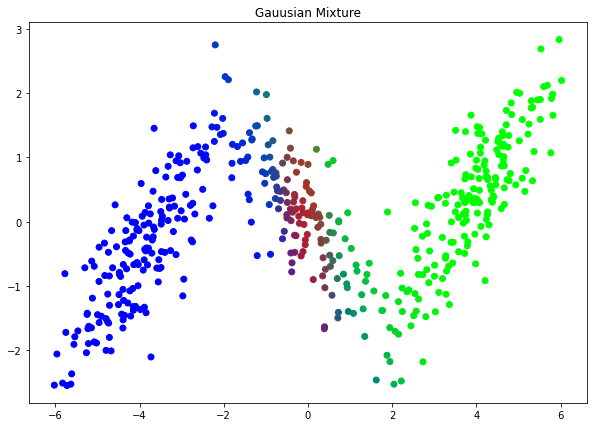

In [11]:
X = gm_sampling(n = 500,pi=pi,mu=mu,sigma=sigma)

km = KMeans(K = 3) 
cluster,_ = km.fit(X)
l2o = LabelToOnehot() 

init_gamma = l2o.fit_transform(cluster) 
init_pi = init_gamma.mean(axis = 0)
init_mu = np.array([X[cluster == 0].mean(axis = 0),X[cluster == 1].mean(axis = 0),X[cluster == 2].mean(axis = 0)])
init_sigma = [] 
for i in range(3):
    tmp = X[cluster == i] - init_mu[i]
    init_sigma.append(tmp.T@tmp)
init_sigma = np.concatenate(init_sigma)

# gm fit 
gm = GaussianMixture(K = 3,max_iter=300)
pi,mu,sigma = gm.fit(X,init_gamma,init_pi,init_mu,init_sigma) 
responsibility = calc_responsibility(X,pi,mu,sigma) 

# plot 
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.scatter(X[:,0],X[:,1],c=responsibility)
ax.set_title("Gauusian Mixture")
plt.show()

# Bernoulli Mixture

In [12]:
class BernoulliMixture():
    def __init__(self,K,max_iter=100,threshold=1e-7):
        self.K = K 
        self.max_iter = max_iter 
        self.threshold = threshold

    def fit(self,X,init_gamma=None,init_pi=None,init_mu=None):
        N = X.shape[0] 
        M = X.shape[1]

        gamma = init_gamma
        pi = init_pi 
        mu = init_mu

        if gamma is None: 
            gamma = np.random.rand(N,self.K) + 0.10
            gamma /= gamma.sum(axis = 1,keepdims=True)
        
        if pi is None:
            pi = np.zeros(self.K)

        if mu is None:
            mu = np.zeros((self.K,M)) 
        
        before_log_likelihood = -np.inf
        for _ in range(self.max_iter):

            # M step 
            N_k = gamma.sum(axis = 0)
            mu = (gamma.T@X) / N_k.reshape(-1,1)
            pi = N_k/N

            # E step 
            tmp = mu.reshape(1,self.K,M)**X.reshape(N,1,M) * (1.0 - mu.reshape(1,self.K,M))**(1.0 - X.reshape(N,1,M))
            bern = np.prod(tmp,axis = 2)*pi 

            log_likelihood = np.sum(np.log(bern.sum(axis = 1))) 
            if abs(before_log_likelihood - log_likelihood) < self.threshold:
                break 
            before_log_likelihood = log_likelihood

            gamma = bern / bern.sum(axis = 1,keepdims=True)

        return pi,mu 

In [13]:
mnist_data = {
    "image": "data/t10k-images-idx3-ubyte.gz",
    "label": "data/t10k-labels-idx1-ubyte.gz"
}

def load_label(file_name):
    file_path = file_name
    with gzip.open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8) 
    return labels

def load_image(file_name):
    file_path = file_name
    with gzip.open(file_path, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16) 
    return images.reshape(-1,28*28)/255.0

def load_mnist():
    image = load_image(mnist_data["image"])
    image = (image > 0.5).astype("int")
    label = load_label(mnist_data["label"])

    idx = np.logical_and(label >= 2,label <= 4)
    return image[idx],label[idx]

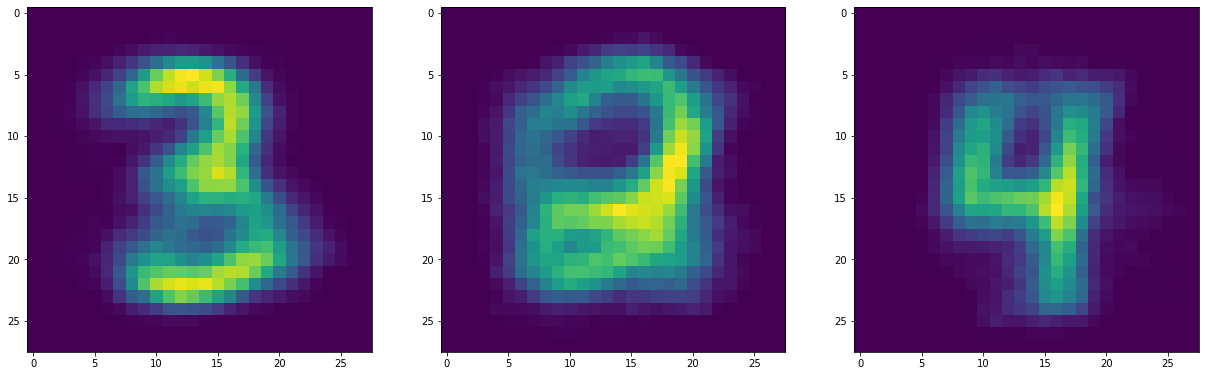

In [14]:
image,label = load_mnist()
image,label = image[:600],label[:600]

bm = BernoulliMixture(K = 3,max_iter=20)
pi,mu = bm.fit(image)

fig,ax = plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(mu[0].reshape(28,28))
ax[1].imshow(mu[1].reshape(28,28))
ax[2].imshow(mu[2].reshape(28,28))
plt.show()